In [1]:
import Pkg
Pkg.activate("../Tasks2D")

  Activating project at `~/Developer/tasks2D/Tasks2D`


In [2]:
using Revise      # For development; makes it so modifications
                  # to imported modules are immediately reflected in this Julia session

import LineWorlds # Local module with code for 2D maps where
                  # the primitive objects are line segments.
const L = LineWorlds
const Geo = L.Geometry;

In [3]:
using Gen

In [4]:
includet("KidnappedRobot/visualization.jl")

## Define environment model

In [5]:
### Initial state distribution ###

mvuniform = L.ProductDistribution(uniform);
@gen function uniform_agent_pos(params)
    mins, maxs = params.bounding_box
    pos ~ mvuniform(mins, maxs)
    
    return pos
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##uniform_agent_pos#314", Bool[0], false)

In [6]:
### Transition model ###

# Load: `det_next_pos`, which computes the determinized effect of actions;
# Load: `handle_wall_intersection` to handle wall intersections
includet("KidnappedRobot/motion_model_utils.jl")

# Motion model accepts the previous world state (the agent position)
# and an action in [:up, :down, :left, :right, :stay]
@gen function motion_model(prev_pos, action, params)
    np = det_next_pos(prev_pos, action, params.step.Δ)
    
    is_kidnapped ~ bernoulli(params.p_kidnapped)

    if !is_kidnapped
        pos ~ broadcasted_normal(np, params.step.σ)
        next_pos = handle_wall_intersection(prev_pos, pos, params.map)
    else # if the robot was kidnapped, it could appear anywhere
        mins, maxs = PARAMS.bounding_box
        pos ~ mvuniform(mins, maxs)
        next_pos = pos
    end
    
    return next_pos
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##motion_model#315", Bool[0, 0, 0], false)

In [7]:
### Observation model ###

# Load: `get_sensor_args`; `sensordist_2dp3`.
includet("KidnappedRobot/sensor_model_utils.jl")

@gen function sensor_model(pos, params)
    sensor_args = get_sensor_args(pos, params)
    obs ~ L.sensordist_2dp3(sensor_args...)
    return obs
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##sensor_model#316", Bool[0, 0], false)

### Define POMDP

In [8]:
import GenPOMDPs

In [9]:
# POMDP of this environment
pomdp = GenPOMDPs.GenPOMDP(
    uniform_agent_pos,       # INIT   : params                      ⇝ state
    motion_model,            # STEP   : prev_state, actions, params ⇝ state
    sensor_model,            # OBS    : state, params               ⇝ observation
    (state, action) -> -1.   # UTILITY: state, action, params       → utility
)

GenPOMDPs.GenPOMDP(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##uniform_agent_pos#314", Bool[0], false), DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##motion_model#315", Bool[0, 0, 0], false), DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##sensor_model#316", Bool[0, 0], false), var"#35#36"())

### Load an environment

In [10]:
# Load function to construct a "hotel" map with a given number
# of identical rooms.
includet("KidnappedRobot/hotel_env.jl")

# Construct a hotel environment with 4 rooms.
(walls, bounding_box) = construct_hotel_env(4);

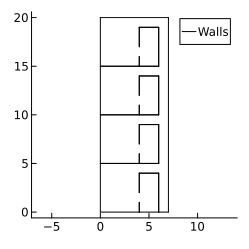

In [11]:
plot(size=(250, 250), aspect_ratio=:equal, grid=false)
plot!(walls, c=:black, label="Walls")

### Add goal object to environment

In [12]:
includet("KidnappedRobot/box.jl") # get `box_segments`, which draws a box out of line segments

# Coordinates for where to place goal object in the map we loaded above
GOAL = [1., 7.]

goalobj = box_segments(GOAL);

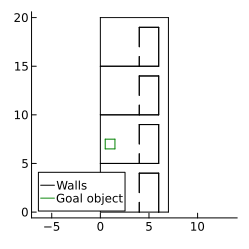

In [20]:
plot(size=(250, 250), aspect_ratio=:equal, grid=false, legend=:bottomleft)
plot!(walls, c=:black, label="Walls")
plot!(goalobj, c=:green, label="Goal object")

### Ground truth world parameters

In [14]:
### Ground truth world model parameters ###
PARAMS = (;
    map = vcat(walls, goalobj), # The map consists of the walls, and the goal object
    p_kidnapped = 0., # Probability the agent is kidnapped on any given step
    bounding_box = bounding_box,
    step = (; Δ = 0.25, σ = 0.005 ), # step model arguments
    obs = (; fov = 2π, n_rays = 80, # obs model arguments
        orientation=π/2,
        sensor_args = (;
            w = 5, s_noise = 0.02,
            outlier = 0.0001, outlier_vol = 100.0,
            zmax = 100.0
)));

### Construct inference algorithm

In [109]:
### Particle Filter args ###

# pf.jl defines `@get_pf`.  This macro just calls GenPOMDPs.pf,
# which constructs a particle filter for a POMDP environment with the given parameters.
# In our case, we will have the particle filter use the ground-truth POMDP, but with different
# parameters than the ground-truth.  (However, we can use inference in a totally different POMDP
# environment to implement the controller, if we want.)
# `pf.jl` also defines some particle filtering proposal distributions based on
# coarse-to-fine grid scans.
includet("KidnappedRobot/pf.jl")

# Also load a file where I defined some default arguments for the particle filter
# proposal distributions.
includet("KidnappedRobot/default_pf_args.jl")

# We will have the agent's mental model suppose the
# motion noise and observation noise are higher than
# they truly are, and the agent will do particle filtering
# assuming kidnapping is impossible.  (It will handle
# kidnapping via a controller which can reset the particle filter.)
INFERENCE_PARAMS = overwrite_params(
    PARAMS;
    p_kidnapped=0.,
    step=(; σ = 0.1),
    sensor_args=(; s_noise=0.1)
)

# arguments for 1 particle SMC
update_grid_args, initialization_grid_args, resampling_args = default_pf_args(INFERENCE_PARAMS; n_particles=1)

pf = @get_pf(pomdp, INFERENCE_PARAMS, update_grid_args, initialization_grid_args, resampling_args);

# The particle filter object returned by GenPOMDPs.pf is a pair of a function
# which initializes a particle filter, `initial_pf_state = pf_init(observation)`, and a function
# which updates the filter, `new_pf_state = pf_update(pf_state, action, new_observation)`.
(pf_init, pf_update) = pf;

## Baseline controller

In [72]:
includet("KidnappedRobot/astar_planning.jl") # Loads: `find_action_using_grid_search`, `taxi_dist`, `get_planning_params`

# Generate a gridworld version of this environment, in which A* planning is feasible.
planning_params = get_planning_params(walls, bounding_box);

In [73]:
includet("KidnappedRobot/handle_sticking.jl") # Loads: `handle_sticking` [see below]

@gen function _baseline_controller(controller_state, obs)
    (prev_pf_state, prev_action) = controller_state

    pf_state = pf_init(choicemap((:obs, obs)))

    # Overlay a cartesian grid on the world, and plan a trajectory to the goal
    # in that grid using A*.  Return the first action of that plan.
    action = find_action_using_grid_search(planning_params, currentpos(pf_state.traces[1]), GOAL)

    # Sometimes, the details of the motion model and the A* planning
    # can cause the agent to "stick" on the walls.
    # This `handle_sticking` function checks if the agent has been trying
    # to perform the same action for multiple timesteps, but its belief state
    # has not changed; if so, it takes a random action orthogonal to the
    # action that is causing sticking.
    action = handle_sticking(prev_pf_state, prev_action, pf_state, action)

    return (action, (pf_state, prev_action))
end

baseline_controller = GenPOMDPs.Controller(
    _baseline_controller, # Controller state, observation ⇝ action, next controller state
    (nothing, nothing)    # Initial controller state
)

GenPOMDPs.Controller(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##_baseline_controller#1737", Bool[0, 0], false), (nothing, nothing))

Now that we have defined the controller, we can get a Generative Function over trajectories from rolling out the true world model, using this controller to choose actions.

In [74]:
baseline_rollout_model = GenPOMDPs.RolloutModel(pomdp, baseline_controller)

GenPOMDPs.var"##StaticGenFunction__RolloutModel#1806"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

Now let's simulate from this model.

First, we'll generate just the initial timestep.

In [75]:
# Start the agent off in a hallway.
INITIAL_POS = [6.5, 4*5 - 2];

┌ Info: Saved animation to /tmp/jl_2Fip4fKp6l.gif
└ @ Plots /home/ubuntu/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_2Fip4fKp6l.gif")
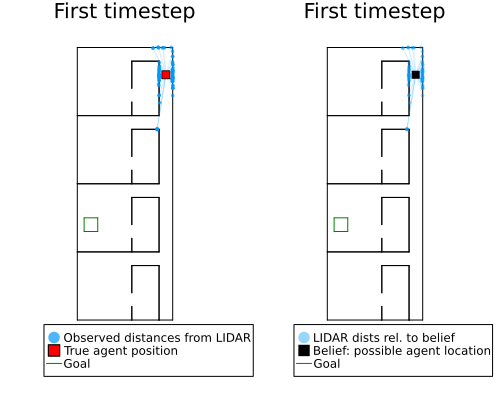

In [76]:
baseline_rollout_tr = Gen.generate(baseline_rollout_model, (0, PARAMS), 
    choicemap((GenPOMDPs.state_addr(0, :pos), INITIAL_POS))
)[1];

trace_to_gif(baseline_rollout_tr; goalobj=goalobj, title="First timestep")

Now, we'll have the model simulate behavior for 100 timesteps.

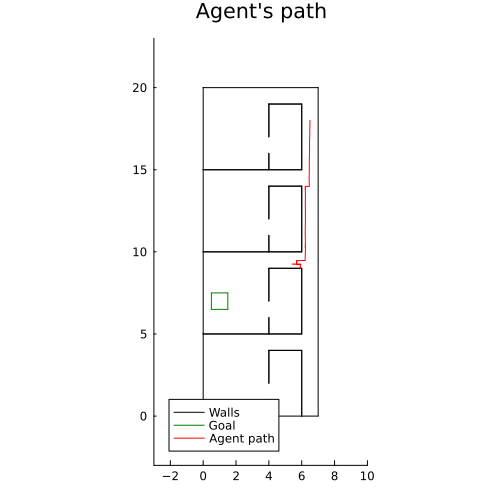

In [78]:
baseline_rollout_tr, _ = Gen.update(
    baseline_rollout_tr,           # Gen "trace" - a detailed record of the roll-out trajectory.
    (100, PARAMS),                 # Update the rollout with time=100; same parameters as before.
    (UnknownChange(), NoChange()), # Time argument changed; parameters didn't.
    EmptyChoiceMap()               # Don't constrain any of the randomness in the roll-out.
                                   # (In principle, we could use this to constrain either environmental
                                   # randomness, or random choices made by the controller in the roll-out.)
)

# Visualize the path the agent took.
trace_to_path_image(baseline_rollout_tr; goalobj=goalobj)

Here's a video of the agent's position and belief, over time.

┌ Info: Saved animation to /tmp/jl_6xYtMnSZgz.gif
└ @ Plots /home/ubuntu/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_6xYtMnSZgz.gif")
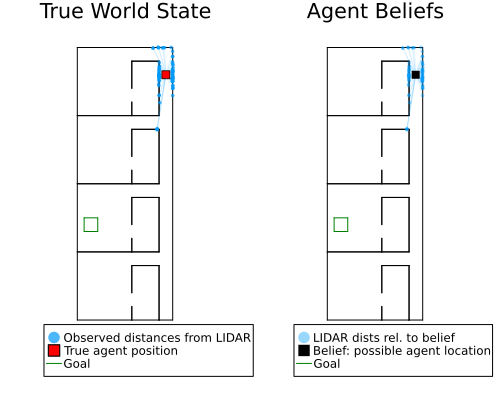

In [79]:
trace_to_gif(baseline_rollout_tr; goalobj=goalobj, fps=10)

The issue with this controller is that it does not remember its belief from the last timestep; it tries to fully relocalize at every step just using its current observations.

The result is that when the agent moves into a hallway into one of the rooms (which looks just like the hallways that lead into each other room), the agent gets confused about where it is.  At each timestep it thinks it is in the hallway toward the goal, it takes a step into the room; at each timestep it thinks it is in another hallway, it takes a step out from the room.  In total, it gets stuck!

## Baseline particle-filtering controller

To fix this, let's use a controller which uses a 1-particle particle filter, rather than re-localizing at each timestep.

In [199]:
@gen function _baseline_pf_controller(controller_state, obs)
    (prev_pf_state, prev_action) = controller_state

    if isnothing(prev_pf_state)
        pf_state = pf_init(choicemap((:obs, obs)))
    else
        pf_state = pf_update(prev_pf_state, prev_action, choicemap((:obs, obs)))
    end

    action = __find_action_using_grid_search(planning_params, currentpos(pf_state.traces[1]), GOAL)
    if action isa Tuple
        action = action[1]
    end
    action = handle_sticking(prev_pf_state, prev_action, pf_state, action)
    
    return (action, (pf_state, action))
end

baseline_pf_controller = GenPOMDPs.Controller(
    _baseline_pf_controller, # Controller state, observation ⇝ action, next controller state
    (nothing, nothing)       # Initial controller state
)

GenPOMDPs.Controller(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##_baseline_pf_controller#5904", Bool[0, 0], false), (nothing, nothing))

In [200]:
baseline_pf_rollout_model = GenPOMDPs.RolloutModel(pomdp, baseline_pf_controller)

GenPOMDPs.var"##StaticGenFunction__RolloutModel#5973"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

┌ Info: Saved animation to /tmp/jl_Yjm1OrUpq3.gif
└ @ Plots /home/ubuntu/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_Yjm1OrUpq3.gif")
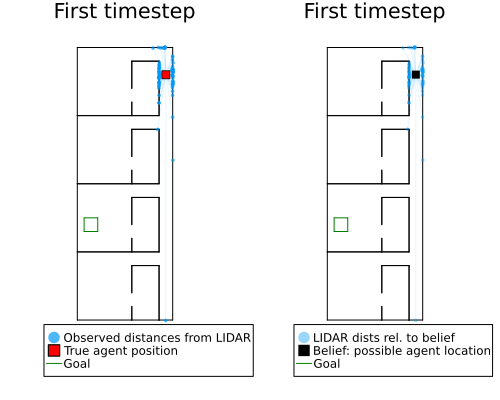

In [112]:
baseline_pf_rollout_tr = Gen.generate(baseline_pf_rollout_model, (0, PARAMS), 
    choicemap((GenPOMDPs.state_addr(0, :pos), INITIAL_POS))
)[1]

trace_to_gif(baseline_pf_rollout_tr; goalobj=goalobj, title="First timestep")

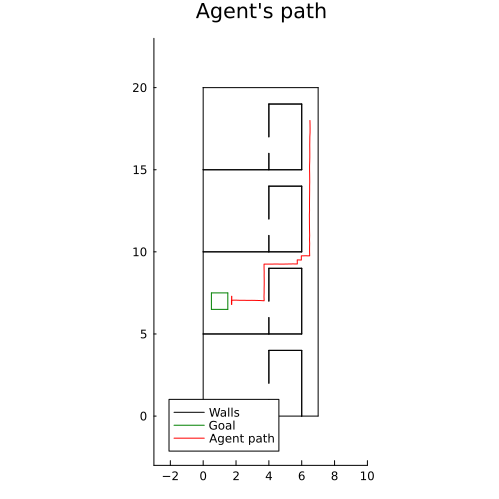

In [113]:
baseline_pf_rollout_tr, _ = Gen.update(baseline_pf_rollout_tr, (100, PARAMS), (UnknownChange(), NoChange()), EmptyChoiceMap())

trace_to_path_image(baseline_pf_rollout_tr; goalobj=goalobj)

┌ Info: Saved animation to /tmp/jl_khe38ZArEp.gif
└ @ Plots /home/ubuntu/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_khe38ZArEp.gif")
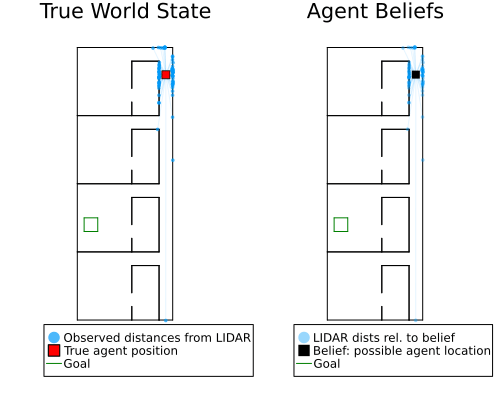

In [114]:
trace_to_gif(baseline_pf_rollout_tr; goalobj=goalobj, fps=10)

## "Kidnap the robot"

┌ Info: Saved animation to /tmp/jl_CLqJQPeheJ.gif
└ @ Plots /home/ubuntu/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_CLqJQPeheJ.gif")
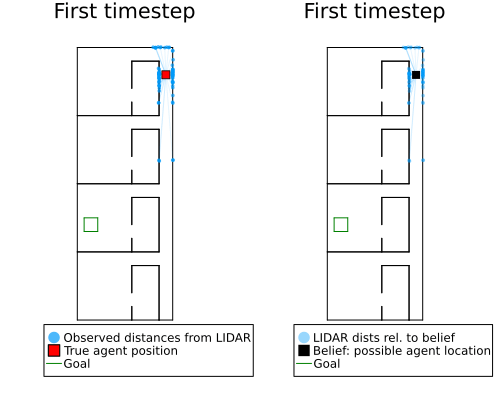

In [116]:
baseline_rollout_tr_KR = Gen.generate(baseline_pf_rollout_model, (0, PARAMS), 
    choicemap((GenPOMDPs.state_addr(0, :pos), INITIAL_POS))
)[1]

trace_to_gif(baseline_rollout_tr_KR; goalobj=goalobj, title="First timestep")

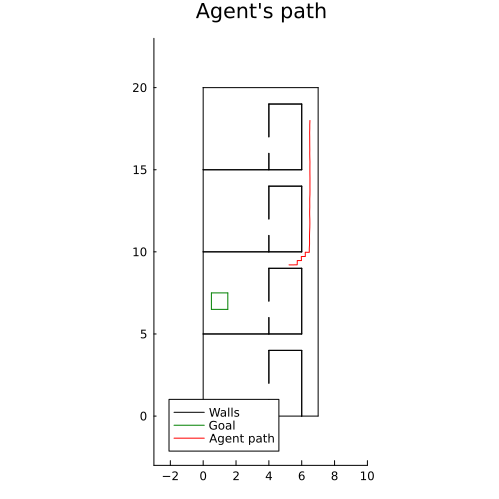

In [117]:
# Extend rollout to 40 steps...
baseline_rollout_tr_KR, _ = Gen.update(baseline_rollout_tr_KR, (40, PARAMS), (UnknownChange(), NoChange()), EmptyChoiceMap());

trace_to_path_image(baseline_rollout_tr_KR; goalobj=goalobj)

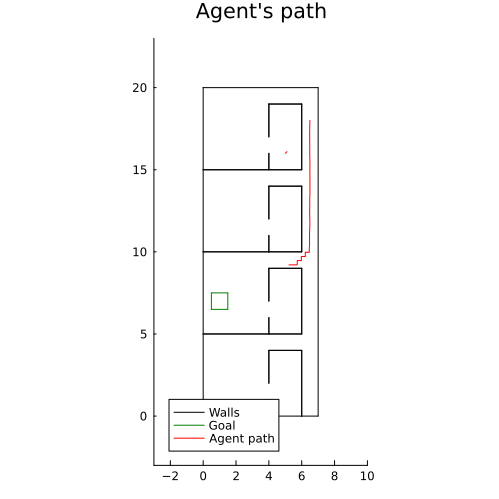

In [120]:
## Kidnap the robot!
baseline_rollout_tr_KR, _ = Gen.update(baseline_rollout_tr_KR, (41, PARAMS), (UnknownChange(), NoChange()),
    choicemap((GenPOMDPs.state_addr(41, :is_kidnapped), true), (GenPOMDPs.state_addr(41, :pos), [5., 16.]))
);

trace_to_path_image(baseline_rollout_tr_KR; goalobj=goalobj, kidnapped_at=[41])

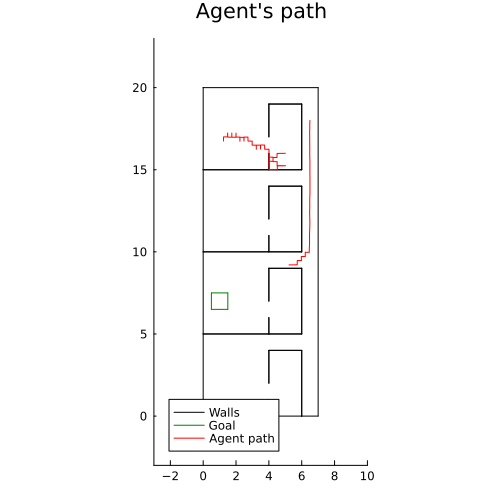

In [123]:
# Roll out the trace another 100 steps
baseline_rollout_tr_KR, _ = Gen.update(baseline_rollout_tr_KR, (140, PARAMS), (UnknownChange(), NoChange()), EmptyChoiceMap());
trace_to_path_image(baseline_rollout_tr_KR; goalobj=goalobj, kidnapped_at=[41])

┌ Info: Saved animation to /tmp/jl_chQFENUZYr.gif
└ @ Plots /home/ubuntu/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_chQFENUZYr.gif")
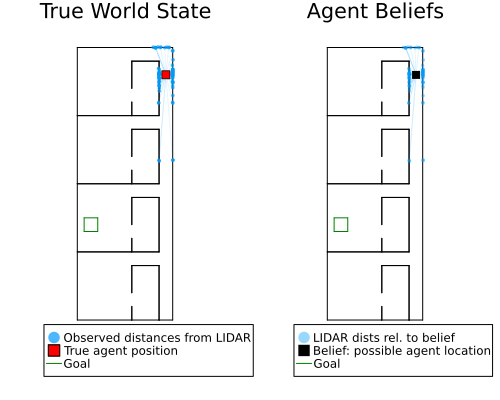

In [126]:
trace_to_gif(baseline_rollout_tr_KR; goalobj=goalobj, fps=10, kidnapped_at=[41])

The particle filter can't handle the robot kidnapping.

One solution would be to have the agent do expensive MCMC rejuvenation at every step, to check if it might have been moved elsewhere.

But we don't need to take on this computational cost.  Instead, we can have the controller make intelligent decisions about on which steps we should spend more computation to re-localize globally.

Below, we'll implement a simple version of this, which resets the particle filter whenever the marginal likelihood estimate from the particle filter (the average particle weight -- and in this case the only particle weight) falls too low.

## Robust controller: particle filtering + reset particle filter when the likelihood falls too low

In [139]:
@gen function _controller(controller_state, obs)
    prev_pf_state, prev_action = controller_state
    
    # Create 1-particle belief state
    if isnothing(prev_action) # First timestep
        pf_state = pf_init(choicemap((:obs, obs)))
    else
        # Log marginal likelihood estimate from the particle filter
        prev_lml_est = GenParticleFilters.get_lml_est(prev_pf_state)

        # Try updating the PF belief state
        pf_state = pf_update(prev_pf_state, prev_action, choicemap((:obs, obs)))
        new_lml_est = GenParticleFilters.get_lml_est(pf_state)

        # We will define and tune this check below
        if incremental_log_likelihood_est_is_too_low(new_lml_est - prev_lml_est)
            # Reset the particle filter!
            # The new pf_state will be over trajectories of length 1.
            pf_state = pf_init(choicemap((:obs, obs)))
        end
    end
    
    # Choose action
    action = find_action_using_grid_search(planning_params, currentpos(pf_state.traces[1]), GOAL)
    action = handle_sticking(prev_pf_state, prev_action, pf_state, action)

    return (action, (pf_state, action))
end

controller = GenPOMDPs.Controller(
    _controller,                     # Controller state, observation ⇝ action, next controller state
    (nothing, nothing)               # Initial controller state
)

GenPOMDPs.Controller(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##_controller#4156", Bool[0, 0], false), (nothing, nothing))

**Tuning the particle filter log marginal likelihood threshold.**

Now, we need to define `incremental_log_likelihood_est_is_too_low`.  This will be a simple
threshold on the estimated value of `P(obs | latent_{t-1})` from the particle filter.

Note that the expected value of `P(obs_t | latent_t)` is `P(obs | latent_{t-1})`.  Based on this observation, we will set our threshold by generating 1000 random (latent, obs) pairs from the model, and setting the threshold to be the minimum value of `P(obs | latent)` which arises.

The intuition here is that if inference were working perfectly, and data were generated from the agent's mental model (not the true world model), then the agent would reset the particle filter approximately 1 out of 1000 steps.  (In practice, this means we will reset the particle filter needlessly 1 out of 1000 steps, and on any step where an inference mistake -- or model misspecification -- causes the inference algorithm's likelihood estimate to look as surprising as a 1 in 1000 occurance.)

[TODO for George: think through the details of this check more carefully.]

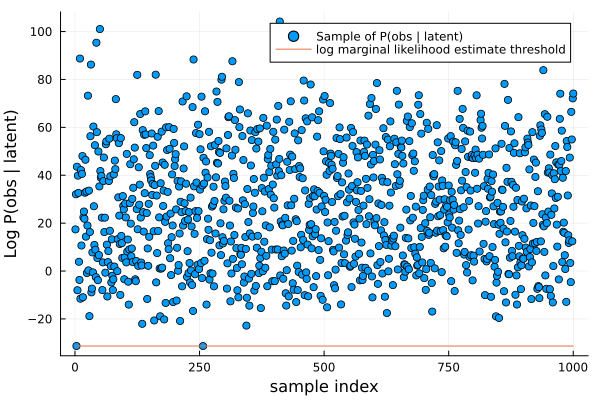

In [140]:
logpy_values = []
for _=1:1000
    state = uniform_agent_pos(INFERENCE_PARAMS)
    obs_tr = simulate(sensor_model, (state, INFERENCE_PARAMS))
    push!(logpy_values, get_score(obs_tr))
end

logpy_threshold = minimum(logpy_values)

function incremental_log_likelihood_est_is_too_low(incremental_logpy_estimate)
    return incremental_logpy_estimate < logpy_threshold
end

scatter(1:1000, logpy_values, ylabel="Log P(obs | latent)", xlabel="sample index", label="Sample of P(obs | latent)")
plot!(1:1000, [logpy_threshold for _=1:1000], label="log marginal likelihood estimate threshold")

**Simulating the robust controller.**

In [141]:
rollout_model = GenPOMDPs.RolloutModel(pomdp, controller)

GenPOMDPs.var"##StaticGenFunction__RolloutModel#4226"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

┌ Info: Saved animation to /tmp/jl_4hOJ6PyV8N.gif
└ @ Plots /home/ubuntu/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_4hOJ6PyV8N.gif")
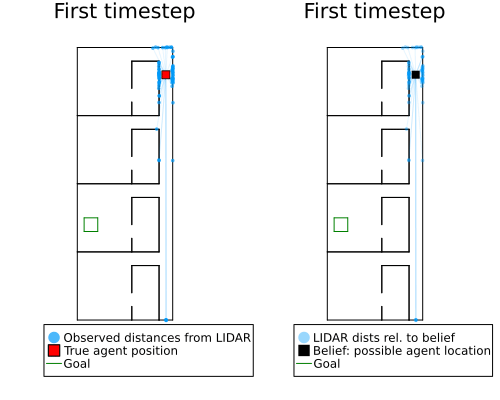

In [142]:
rollout_tr = Gen.generate(rollout_model, (0, PARAMS), 
    choicemap((GenPOMDPs.state_addr(0, :pos), INITIAL_POS))
)[1]

trace_to_gif(rollout_tr; goalobj=goalobj, title="First timestep")

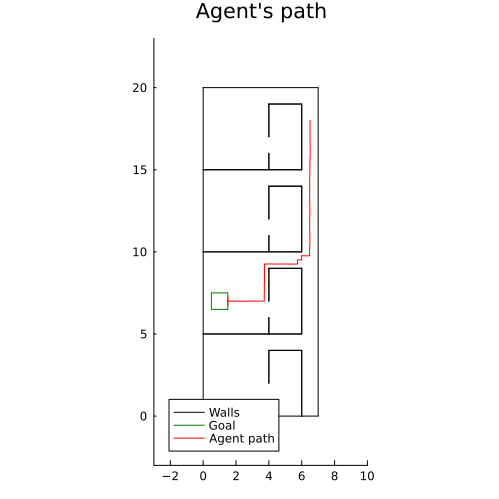

In [144]:
# Extend rollout...
rollout_tr, _ = Gen.update(rollout_tr, (80, PARAMS), (UnknownChange(), NoChange()), EmptyChoiceMap());

trace_to_path_image(rollout_tr; goalobj=goalobj)

┌ Info: Saved animation to /tmp/jl_Q9OtSbOJM3.gif
└ @ Plots /home/ubuntu/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_Q9OtSbOJM3.gif")
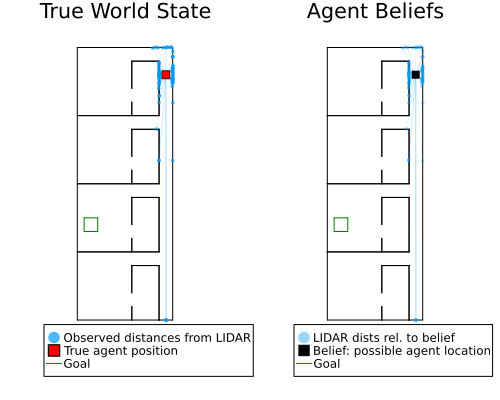

In [145]:
trace_to_gif(rollout_tr; goalobj=goalobj, fps=10)

### Kidnapped robot with the robust controller

┌ Info: Saved animation to /tmp/jl_ehW925SBwz.gif
└ @ Plots /home/ubuntu/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_ehW925SBwz.gif")
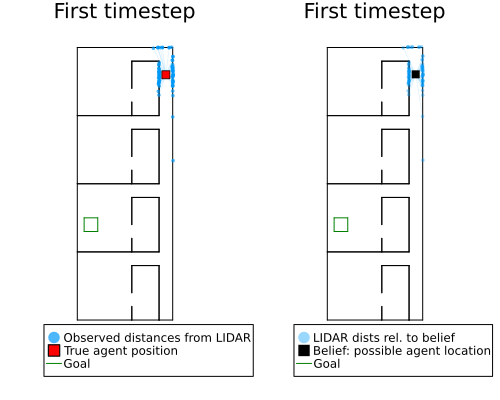

In [155]:
robust_rollout_tr_KR = Gen.generate(rollout_model, (0, PARAMS), 
    choicemap((GenPOMDPs.state_addr(0, :pos), INITIAL_POS))
)[1]

trace_to_gif(robust_rollout_tr_KR; goalobj=goalobj, title="First timestep")

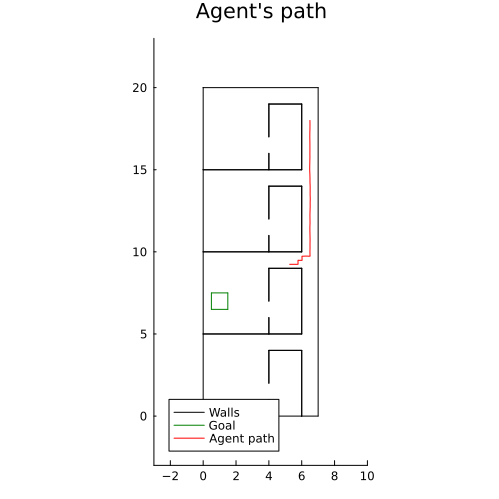

In [156]:
# Extend rollout to 40 steps...
robust_rollout_tr_KR, _ = Gen.update(robust_rollout_tr_KR, (40, PARAMS), (UnknownChange(), NoChange()), EmptyChoiceMap());

trace_to_path_image(robust_rollout_tr_KR; goalobj=goalobj)

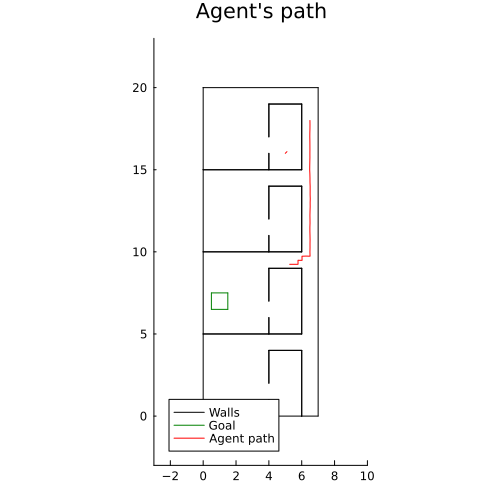

In [157]:
## Kidnap the robot!
robust_rollout_tr_KR, _ = Gen.update(robust_rollout_tr_KR, (41, PARAMS), (UnknownChange(), NoChange()),
    choicemap((GenPOMDPs.state_addr(41, :is_kidnapped), true), (GenPOMDPs.state_addr(41, :pos), [5., 16.]))
);

trace_to_path_image(robust_rollout_tr_KR; goalobj=goalobj, kidnapped_at=[41])

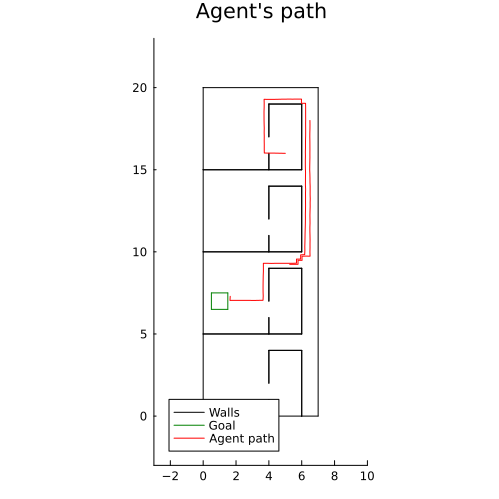

In [158]:
# Roll out the trace another 100 steps
robust_rollout_tr_KR, _ = Gen.update(robust_rollout_tr_KR, (140, PARAMS), (UnknownChange(), NoChange()), EmptyChoiceMap());
trace_to_path_image(robust_rollout_tr_KR; goalobj=goalobj, kidnapped_at=[41])

┌ Info: Saved animation to /tmp/jl_0LcnaTIBW7.gif
└ @ Plots /home/ubuntu/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_0LcnaTIBW7.gif")
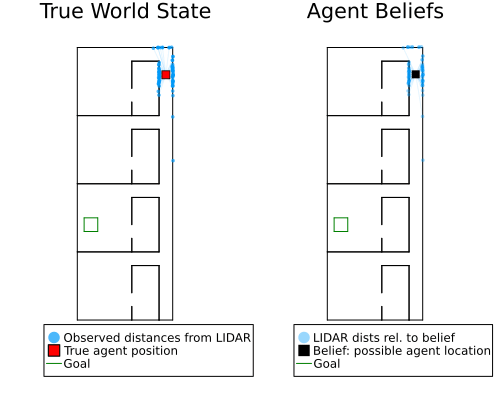

In [159]:
trace_to_gif(robust_rollout_tr_KR; goalobj=goalobj, fps=10, kidnapped_at=[41])

## Plotting the runtime and effectiveness of each controller

In [160]:
includet("KidnappedRobot/measure_performance.jl") # Loads `take_measurement`, `take_measurement_KR`

In [179]:
robust_costs_runtimes = [take_measurement(rollout_model) for _=1:10];

In [162]:
baseline1_costs_runtimes = [take_measurement(baseline_rollout_model) for _=1:10];

In [170]:
baselinepf_costs_runtimes = [take_measurement(baseline_pf_rollout_model) for _=1:10];

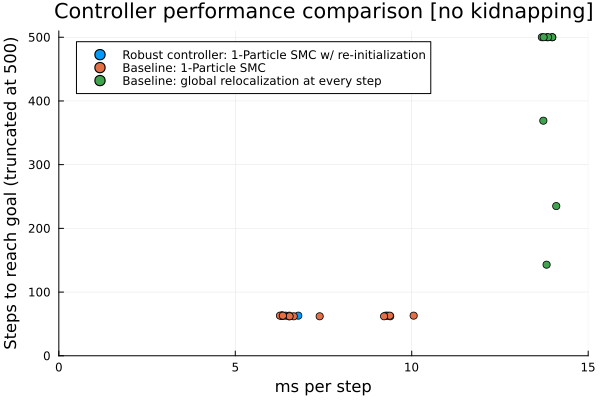

In [181]:
plot(;
    title="Controller performance comparison [no kidnapping]",
    ylabel="Steps to reach goal (truncated at 500)",
    xlabel="ms per step",
    ylims=(0, 510),
    xlims=(0,15)
)
scatter!(map(x->x[2]*1000, robust_costs_runtimes), map(x->x[1], robust_costs_runtimes), label="Robust controller: 1-Particle SMC w/ re-initialization")
scatter!(map(x->x[2]*1000, baselinepf_costs_runtimes), map(x->x[1], baselinepf_costs_runtimes), label="Baseline: 1-Particle SMC")
scatter!(map(x->x[2]*1000, baseline1_costs_runtimes), map(x->x[1], baseline1_costs_runtimes), label="Baseline: global relocalization at every step")

In [176]:
robust_costs_runtimes_KR = [take_measurement_KR(rollout_model) for _=1:10];

In [177]:
baseline1_costs_runtimes_KR = [take_measurement_KR(baseline_rollout_model) for _=1:10];

In [201]:
baselinepf_costs_runtimes_KR = [take_measurement_KR(baseline_pf_rollout_model) for _=1:10];

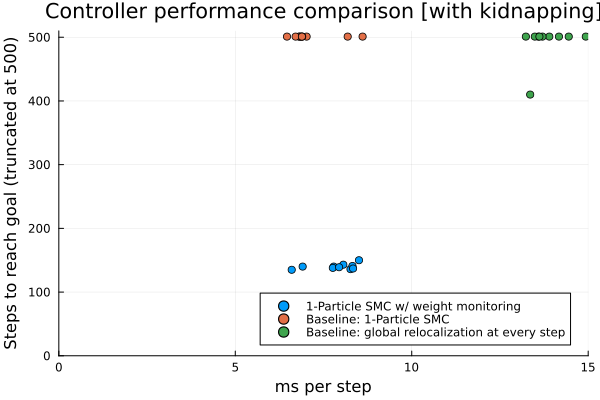

In [205]:
plot(;
    title="Controller performance comparison [with kidnapping]",
    ylabel="Steps to reach goal (truncated at 500)",
    xlabel="ms per step",
    ylims=(0, 510),
    xlims=(0,15),
    legend=:bottomright
)
scatter!(map(x->x[2]*1000, robust_costs_runtimes_KR), map(x->x[1], robust_costs_runtimes_KR), label="1-Particle SMC w/ weight monitoring")
scatter!(map(x->x[2]*1000, baselinepf_costs_runtimes_KR), map(x->x[1], baselinepf_costs_runtimes_KR), label="Baseline: 1-Particle SMC")
scatter!(map(x->x[2]*1000, baseline1_costs_runtimes_KR), map(x->x[1], baseline1_costs_runtimes_KR), label="Baseline: global relocalization at every step")